In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime

In [4]:
def json_to_pd(fname):
    '''read json file, convert to pandas dataframe'''
    
    with open(fname) as the_file:
        dict_fname = json.load(the_file)
    return pd.DataFrame(dict_fname)

def get_range(column):
    '''Accept dataframe column return tuple with max and min'''
    return(min(column),max(column))

fname='ultimate_data_challenge.json'
train_df=json_to_pd(fname)

for c in train_df.columns:
    try:
        print '{} has a range of {}'.format(c,get_range(train_df[c].values))
    except:
        pass



avg_dist has a range of (0.0, 160.96000000000001)
avg_rating_by_driver has a range of (1.0, 5.0)
avg_rating_of_driver has a range of (1.0, 5.0)
avg_surge has a range of (1.0, 8.0)
city has a range of (u'Astapor', u'Winterfell')
last_trip_date has a range of (u'2014-01-01', u'2014-07-01')
phone has a range of (None, u'iPhone')
signup_date has a range of (u'2014-01-01', u'2014-01-31')
surge_pct has a range of (0.0, 100.0)
trips_in_first_30_days has a range of (0, 125)
ultimate_black_user has a range of (False, True)
weekday_pct has a range of (0.0, 100.0)


In [5]:
#Look for missing values
train_df.info(null_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [6]:
# There are three features with missing values, Two are numeric and one is categorical.  
# To make a decision on how to deal with these values, we need the target variable to judge 
# impact

# To get target, use last_trip_date-start_date in months to be greater than 5.  Per
#the instructions a user is retained if he has taken a trip in the preceeding 30 days.  That means that he is retained in month 
# six if he takes a ride in month 5.

# Because of the specifics of this dataset, we can use simple math (all signups occurred in January, so anyone that took a last ride
# in June or later was retained for six months)

# Note: this is a very important assuption,as the results would be completely different if you
#used a different retention rule.  As an example, I could have used time delta of 180 days 
#to represent a customer retained for six months.


def make_date_tuple(string):
    tmp=string.split('-')
    return (int(tmp[0]),int(tmp[1]),int(tmp[2]))

train_df['st_date']=train_df.signup_date.apply(make_date_tuple)
train_df['lr_date']=train_df.last_trip_date.apply(make_date_tuple)
train_df['months_retained']=train_df.apply(lambda x: x.lr_date[1]-x.st_date[1],axis=1)
train_df['target']=train_df.apply(lambda x: 1 if x.months_retained >=5 else 0,axis=1)
train_df.drop(['st_date','lr_date','months_retained'],inplace=True,axis=1)
train_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,target
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


With a target variable, it is now possible to decide how to treat missing values.  Look first at phone type.  Note: there are only two types in the data: iPhone and Android, and would really reflect differences in app quality.

In [7]:
iphone=train_df.loc[train_df.phone=='iPhone','target'].mean()
android=train_df.loc[train_df.phone=='Android','target'].mean()
none=train_df.loc[(train_df.phone!='Android') & (train_df.phone!='iPhone'),'target'].mean()
print iphone,android,none

0.44893297091 0.209426174943 0.335858585859


There is a large difference between the Android and iPhonoe customers.  First this means that we can't simply chose a phone type for missing values.  Nans will be filled in with a string "None given".  Additionally, this is an import thing to pass along to the client.  THere should be no difference in customer retention based on phone type.

In [8]:
tmp=train_df.copy()
tmp.dropna(axis=0,inplace=True)
print np.corrcoef(tmp.target,tmp.avg_rating_of_driver)

[[ 1.         -0.01182859]
 [-0.01182859  1.        ]]


The 2 dimensional correlation between average rating of driver to target is low, so I am filling in the missing values with the average.  I expect this to have minimal impact

In [9]:
avg_of_driver=tmp.avg_rating_of_driver.mean()

avg_by_driver=tmp.avg_rating_by_driver.mean()
print avg_of_driver,avg_by_driver

train_df['avg_rating_of_driver'].fillna(avg_of_driver,inplace=True)
train_df['avg_rating_by_driver'].fillna(avg_by_driver,inplace=True)
train_df['phone'].fillna('Missing Phone Type',inplace=True)
train_df.info(null_counts=True)

4.60172035227 4.77644589215
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
target                    50000 non-null int64
dtypes: bool(1), float64(6), int64(2), object(4)
memory usage: 4.6+ MB


In [10]:
#Question1:  What percentage of the users were retained?
print '{:4.1f}% of users were retained.'.format(train_df.target.mean()*100)

37.6% of users were retained.


In [11]:
#prep model columns.
# categorical variables will be city and phone
#last_trip_date will be dropped as that will cause leakage to the target
#signup date will be converted to an integer that represents the day (month and year are common across all lines)

train_df=pd.get_dummies(train_df,columns=['phone','city'])
train_df['signup']=train_df.apply(lambda x: x.signup_date.split('-')[2],axis=1)
target=train_df.target
train_df.drop(['last_trip_date','signup_date','target'],inplace=True,axis=1)
train_df['ultimate_black_user']=train_df['ultimate_black_user'].astype(int)
print target[:5]
train_df.head()

0    1
1    0
2    0
3    1
4    0
Name: target, dtype: int64


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,phone_Android,phone_Missing Phone Type,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell,signup
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0,0,1,0,1,0,25
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,1,0,0,1,0,0,29
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,0,1,1,0,0,06
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,0,0,1,0,1,0,10
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,1,0,0,0,0,1,27


*Note*:  In the interest of time, two decisions were made that drive the overall solution:  

 1) A single classifier is optimized, fit, and evaluated.  However, the code is written so
    other classifiers can be tried by simply supplying a difference parameter set.  All
    metrics will be reported on a similar basis.

 2) RandomizedSearch is used rather than grid search.  This data is relatively small, but
   in a larger dataset, GridSearch can be prohibitive from a computational standpoint.  The code is written so that is an easy change to make.

In [12]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc,roc_auc_score
import sklearn.cross_validation as cv
import sklearn.feature_selection as feature_selection

def randomly_optimize_classifier(clf,name,train_df,target,param_search,\
                n_iter=10,scoring='roc_auc',cv_num=5,verbose=50,\
                random_state=0,test_size=0.33,n_jobs=2):#5
    
    tmp_df=train_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(\
        train_df, target, test_size=test_size,random_state=random_state)

    clf=RandomizedSearchCV(clf,param_search,scoring=scoring,\
        cv=cv_num,n_iter=n_iter,verbose=verbose,n_jobs=n_jobs)
    
    clf.fit(X_train,y_train)

    rocky=roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    print '{} has a roc_aucscore_of {:6.5f}'.format(name,rocky)
    
    print name+'Best Params',clf.best_params_
    print name+'Best Score',clf.best_score_
    print name+'_score',clf.score(X_test, y_test)
    print '\n'
    
    

    return clf,X_train,X_test,y_train,y_test
        
    
n_iter=5   
rf_name='Random Forrest Classifier'

rf_param_search={'n_estimators':[10,50,100,200,400],
                 'criterion':['gini'],
                 'max_features':['sqrt','log2'],
                 'max_depth':[2,4,6],
                 'min_samples_split':[2,4,6],
                 'min_samples_leaf':[1,2,3]}


rf=RandomForestClassifier()
rf_opt,X_train,X_test,y_train,y_test=randomly_optimize_classifier(rf,rf_name,train_df,\
        target,rf_param_search,n_iter=n_iter,n_jobs=5)

C:\Users\Bill\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   10.8s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   12.6s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:   14.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:   15.7s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:   16.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   17.6s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:   17.7s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:   18.2s
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:   19.0s
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:   19.3s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:   19.5s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:   19.6s
[Parallel(n_jobs=5)]: Don

In [13]:
# Note: Randomized Optimizer does not return feature importances.  It is necessary to fit a true
# RF classifers to get them.  Using the best parameters from above:

rf=RandomForestClassifier(min_samples_leaf=1, n_estimators=400, max_features='log2',\
                criterion='gini', min_samples_split=4, max_depth=6)

rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

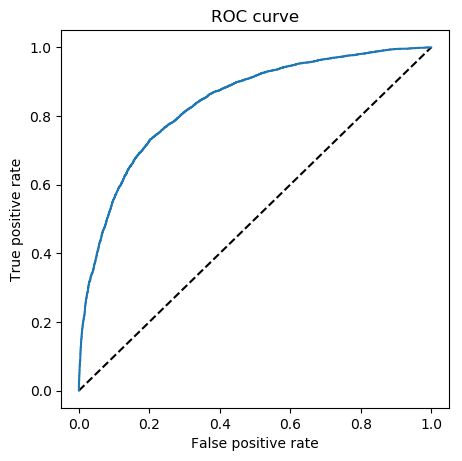

In [17]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr_rf, tpr_rf)


plt.figure(figsize=(5,5),dpi=100)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
#print "%8.6f\t%8.6f\t%d\t%s\t%8.6f"%((con_f[0,0]+con_f[1,1])/float(total),con_f[0,1]/float(total),n,mx,roc_auc)
#print '%8.6f\t%d\t\t%s\t\t\t%d\t\t%d'%(roc_auc,n,mx,ms,msl)

                    
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.show()

In [50]:
y_pred=rf.predict(X_test)
print y_test[:10]
print y_pred[:10]
con_mat=confusion_matrix(y_true=y_test,y_pred=y_pred)
print con_mat.view()

11841    0
19602    0
45519    0
25747    1
42642    0
31902    1
30346    0
12363    0
32490    1
26128    0
Name: target, dtype: int64
[0 0 0 0 0 1 0 0 1 0]
[[9172 1161]
 [2531 3636]]


In [18]:
feature_df=pd.DataFrame()
feature_df['feats']=train_df.columns
feature_df['importances']=rf.feature_importances_
feature_df.sort_values('importances',ascending=False,inplace=True)
feature_df.head(5)

,feats,importances
1,avg_rating_by_driver,0.207810
4,surge_pct,0.149223
12,city_King's Landing,0.129221
3,avg_surge,0.117351
7,weekday_pct,0.101238


The cell above shows the features for the random forrest model created ranked by importance.  Intuitively, much of it make some sense.  A the rating by the driver represents a loose analysis of the customer's behaviour (did she tip well? was he friendly? etc.) all of which can reflect a customer's experience on the trip.  Surge pricing shows up twice in the top ten, weekday percentage has a likely correlation with business use, etc.  

However, there are two surprising things in the list.  King's Landing is a topve feature and Astapor and Winterfell are significantly less important.   Looking at the relative representations in the data(below) it is clear that King's Landing is the lowest represented city.  From this data, we can't conclude why, but it is worth highlighting to the client.  They should examine the differences between cities and apply any learnings from King's Landing to the other cities.

Finally, average rating of driver, which is a measure of the average ranking a driver recieves from custmomers is quite low (nearly zero impact.)  This supports the idea that for this case, direct customer feedback is less important than measuring their actions.

In [16]:
print '{} is {:4.1f}% of the data'.format('Winterfell',100*train_df.city_Winterfell.mean())
print '{} is {:4.1f}% of the data'.format('Astapor',100*train_df.city_Astapor.mean())
print '{} is {:4.1f}% of the data'.format("King's Landing",100*train_df["city_King's Landing"].mean())


Winterfell is 46.7% of the data
Astapor is 33.1% of the data
King's Landing is 20.3% of the data


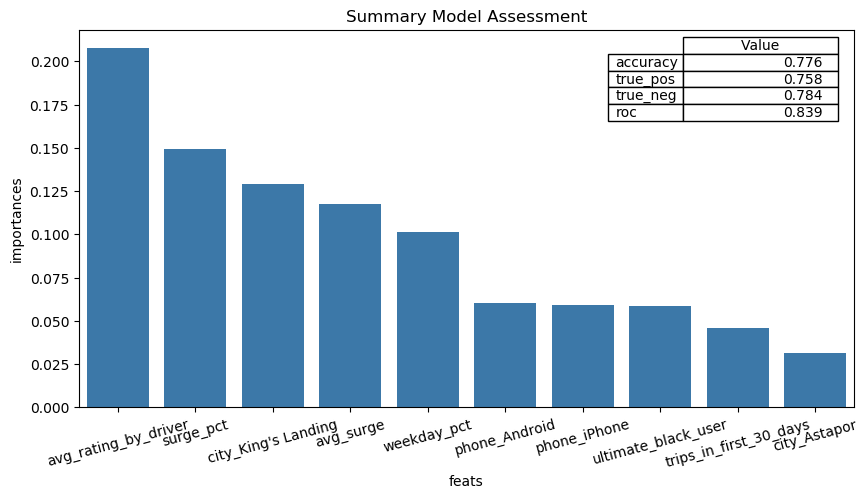

In [82]:
feat_plt=feature_df.head(10)
feat_plt.reset_index(drop=True,inplace=True)

from pandas.plotting import table

#table1=table(data=pd.DataFrame(['roc','my','butt'],[1,2,3]))
#plt.table(table1,loc='best')


fig, ax = plt.subplots(1, 1)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.set_dpi(100)

perf_table=pd.DataFrame(index=['accuracy','true_pos','true_neg','roc'],columns=['Value'])
perf_table.loc['accuracy','Value']='{:4.3f}'.format(float((con_mat[0,0]+con_mat[1,1]))/con_mat.sum())
perf_table.loc['true_pos','Value']='{:4.3f}'.format(float(con_mat[1,1])/(con_mat[0,1]+con_mat[1,1]))
perf_table.loc['true_neg','Value']='{:4.3f}'.format(float(con_mat[0,0])/(con_mat[0,0]+con_mat[1,0]))
perf_table.loc['roc','Value']='{:4.3f}'.format(roc_auc)




table(ax, perf_table,loc='upper right', colWidths=[0.2, 0.2, 0.2])

pal=sns.color_palette("Blues")
sns.barplot(x='feats',y='importances',data=feat_plt,color=pal[4])
plt.title('Summary Model Assessment')
plt.xticks(rotation=15)
plt.savefig('Model Assessment')
plt.show()